In [1]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
import itertools
import warnings
warnings.simplefilter('ignore')
%run -i 'functions.py'

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
ERROR:root:File `'functions.py'` not found.


In [2]:
pd.set_option('display.max_columns', None)
train= pd.read_csv('clean_train.csv')
test= pd.read_csv('clean_test.csv')

In [3]:
train.shape

(59400, 237)

In [4]:
test.shape

(14850, 235)

In [5]:
train.dtypes

id                                               int64
status_group                                     int64
amount_tsh                                     float64
date_recorded                                   object
funder                                          object
                                                ...   
waterpoint_type_communal standpipe multiple      int64
waterpoint_type_dam                              int64
waterpoint_type_hand pump                        int64
waterpoint_type_improved spring                  int64
waterpoint_type_other                            int64
Length: 237, dtype: object

In [6]:
train.columns.difference(test.columns)

Index(['scheme_management_None', 'status_group'], dtype='object')

In [7]:
train.drop(columns = ['scheme_management_None',], inplace=True)

In [8]:
train.shape,test.shape

((59400, 236), (14850, 235))

## Feature Set

In [9]:
X = train.drop(columns = ['id', 'status_group','date_recorded','funder','installer']).values
y = train['status_group'].values
X_r, y_r = SMOTE().fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

In [10]:
print('Training set: ', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

Training set:  (77421, 231) (77421,)
Testing set:  (19356, 231) (19356,)


## Dummy Classifier 

In [74]:
dummy_clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
dummy_pred = dummy_clf.predict(X_test)
dummy_clf.score(X_train, y_train)

0.3342245643946733

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=2)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [76]:
cm = confusion_matrix(y_test,dummy_pred)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[   0    0 6540]
 [   0    0 6433]
 [   0    0 6383]]


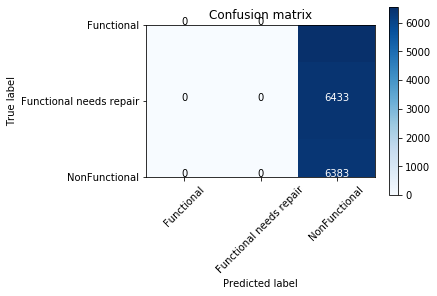

In [77]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Random Classifier 

In [71]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=None).fit(X_train, y_train)

In [79]:
yhat = rfc.predict(X_test)

In [81]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8361038994588031
Test set Accuracy:  0.8221740028931598


## Hyper Tuning Random Forest 

In [88]:
param_grid = {
    'n_estimators': [50, 100],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf':[2,4],
    'min_samples_split':[3,5],
    'bootstrap': [True, False]
}


grid_rfc = GridSearchCV(RandomForestClassifier(), 
                        rfc_params, 
                        cv=3, 
                        scoring='accuracy').fit(X_train, y_train)

In [89]:
gridsearch_ = grid_rfc.predict(X_test)


In [91]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, grid_rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, gridsearch_))

Train set Accuracy:  0.9679544309683419
Test set Accuracy:  0.8627299028724943


In [92]:
cm = confusion_matrix(yhat,gridsearch_)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[5925 2287  632]
 [ 192 3597   87]
 [ 670  708 5258]]


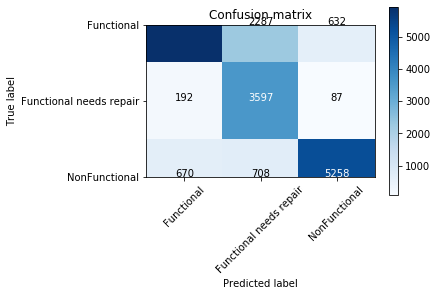

In [93]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Predicitons

In [96]:
testdf = test.drop(columns = ['id','date_recorded','funder','installer']).values

In [97]:
yhat2 = grid_rfc.predict(testdf)

In [98]:
prediction = pd.DataFrame(yhat2)

In [104]:
prediction.head()

,0
0,2
1,0
2,0
3,2
4,0


In [106]:
prediction = pd.concat((test['id'], prediction), axis=1)

In [107]:
prediction.columns=['id', 'status_group']

In [115]:
prediction.head()

,id,status_group
0,50785,2
1,51630,0
2,17168,0
3,45559,2
4,49871,0


In [204]:
prediction.shape

(14850, 2)

These are value counts the status group that I predicted from the test set. There are 8165 Functional pumps, 5506 Non Functional pumps, and 1179 Functional needs repair. 

In [113]:
prediction['status_group'].value_counts()

0    8165
2    5506
1    1179
Name: status_group, dtype: int64

In [200]:
functional = len(prediction[prediction['status_group']==0])
nonfunctional = len(prediction[prediction['status_group']==2])
needsrepair = len(prediction[prediction['status_group']==1])
pct_functional= functional/(functional+nonfunctional+needsrepair)
pct_nonfunctional = nonfunctional/(functional+nonfunctional+needsrepair)
pct_needsrepair = needsrepair/(functional+nonfunctional+needsrepair)
print("percentage of functional water pumps is", pct_functional*100)
print("percentage of nonfunctional water pump", pct_nonfunctional*100)
print("percentage of functional but needs repair water pump", pct_needsrepair*100)

percentage of functional water pumps is 54.983164983164976
percentage of nonfunctional water pump 37.07744107744107
percentage of functional but needs repair water pump 7.9393939393939394


In comparisson to train dataset. These are value counts the status group from the train dataset. 

In [114]:
train['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [201]:
functional = len(train[train['status_group']==0])
nonfunctional = len(train[train['status_group']==2])
needsrepair = len(train[train['status_group']==1])
pct_functional= functional/(functional+nonfunctional+needsrepair)
pct_nonfunctional = nonfunctional/(functional+nonfunctional+needsrepair)
pct_needsrepair = needsrepair/(functional+nonfunctional+needsrepair)
print("percentage of functional water pumps is", pct_functional*100)
print("percentage of nonfunctional water pump", pct_nonfunctional*100)
print("percentage of functional but needs repair water pump", pct_needsrepair*100)

percentage of functional water pumps is 54.3080808080808
percentage of nonfunctional water pump 38.42424242424242
percentage of functional but needs repair water pump 7.267676767676767


## KNN

In [116]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

y_predknn = model.predict(X_test)

In [118]:
cm = confusion_matrix(y_test, y_predknn)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[4502 1009 1029]
 [ 579 5618  236]
 [1396  743 4244]]


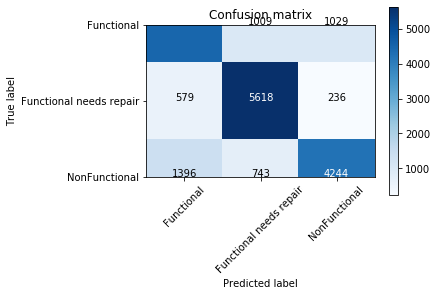

In [119]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Identifying the best K value

In [142]:
from sklearn.model_selection import cross_val_score

In [146]:
k_range = list(range(1, 12))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)   

[0.6781481481481482, 0.6877777777777777, 0.6996127946127947, 0.7003030303030303, 0.7021548821548821, 0.7036868686868687, 0.7034175084175084, 0.7043097643097643, 0.7048484848484848, 0.7052525252525252, 0.7038720538720539]


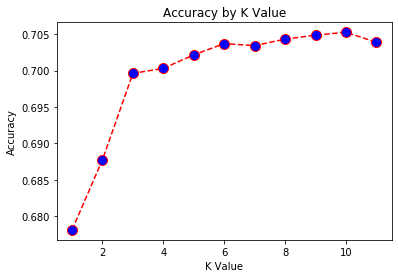

In [153]:
plt.plot(range(1, 12), k_scores, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
plt.title('Accuracy by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy') 
plt.show()

In [163]:
print ( "The best value of K is 10, with an accuracy of", max(k_scores))

The best value of K is 10, with an accuracy of 0.7052525252525252


In [150]:
model2 = KNeighborsClassifier(n_neighbors=1)
model2.fit(X_train, y_train)

y_predknnbest = model2.predict(X_test)

In [151]:
cm1 = confusion_matrix(y_test,y_predknnbest)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[4450  739 1351]
 [ 472 5711  250]
 [1027  409 4947]]


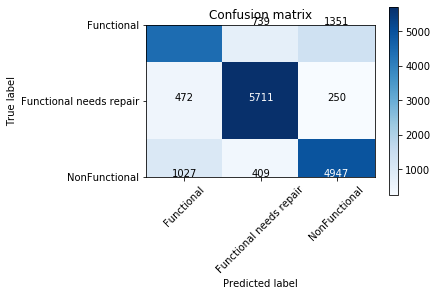

In [152]:
plot_confusion_matrix(cm1, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### KNN Predictions

In [183]:
testdf = test.drop(columns = ['id','date_recorded','funder','installer']).values

In [184]:
knnpredict= knn.predict(testdf)

In [185]:
predsknn= pd.DataFrame(knnpredict)

In [186]:
predsknn.head()

,0
0,0
1,0
2,0
3,2
4,0


In [187]:
predictionknn = pd.concat((test['id'], predsknn), axis=1)

In [196]:
predictionknn.head()

,id,status_group
0,50785,0
1,51630,0
2,17168,0
3,45559,2
4,49871,0


In [203]:
predictionknn.shape

(14850, 2)

In [191]:
predictionknn.columns=['id', 'status_group']

These are value counts the status group that I predicted from the test set. There are 6356 Functional pumps, 5330 Non Functional pumps, and 3164 Functional needs repair.

In [194]:
predictionknn['status_group'].value_counts()

0    6356
2    5330
1    3164
Name: status_group, dtype: int64

In [199]:
functional = len(predictionknn[predictionknn['status_group']==0])
nonfunctional = len(predictionknn[predictionknn['status_group']==2])
needsrepair = len(predictionknn[predictionknn['status_group']==1])
pct_functional= functional/(functional+nonfunctional+needsrepair)
pct_nonfunctional = nonfunctional/(functional+nonfunctional+needsrepair)
pct_needsrepair = needsrepair/(functional+nonfunctional+needsrepair)
print("percentage of functional water pumps is", pct_functional*100)
print("percentage of nonfunctional water pump", pct_nonfunctional*100)
print("percentage of functional but needs repair water pump", pct_needsrepair*100)

percentage of functional water pumps is 42.8013468013468
percentage of nonfunctional water pump 35.89225589225589
percentage of functional but needs repair water pump 21.306397306397308


Comparing to the training dataset

In [202]:
functional = len(train[train['status_group']==0])
nonfunctional = len(train[train['status_group']==2])
needsrepair = len(train[train['status_group']==1])
pct_functional= functional/(functional+nonfunctional+needsrepair)
pct_nonfunctional = nonfunctional/(functional+nonfunctional+needsrepair)
pct_needsrepair = needsrepair/(functional+nonfunctional+needsrepair)
print("percentage of functional water pumps is", pct_functional*100)
print("percentage of nonfunctional water pump", pct_nonfunctional*100)
print("percentage of functional but needs repair water pump", pct_needsrepair*100)

percentage of functional water pumps is 54.3080808080808
percentage of nonfunctional water pump 38.42424242424242
percentage of functional but needs repair water pump 7.267676767676767


## Logistic Regression

In [14]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

print('Train set Accuracy: ', metrics.accuracy_score(y_train, logistic_regression.predict(X_train)))
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Train set Accuracy:  0.4309941747071208
Accuracy:  0.4259661087001447


In [15]:
cm = confusion_matrix(y_test,y_pred)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[2543  902 3095]
 [1742 1863 2828]
 [1742  802 3839]]


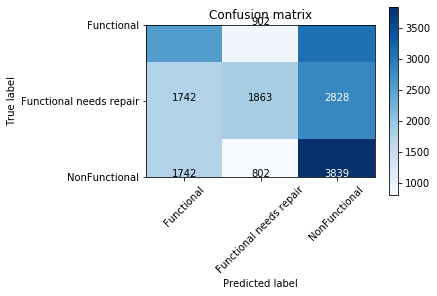

In [16]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## HyperTuning 

In [17]:
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[100,110,120,140,200,1000,2000],'max_iter':[150,250,350,450],'dual':[True,False]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, verbose=0, cv=10)
grid_clf_acc.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [100, 110, 120, 140, 200, 1000, 2000],
                         'dual': [True, False],
                         'max_iter': [150, 250, 350, 450],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
grid_clf_acc.best_params_

{'C': 120, 'dual': False, 'max_iter': 450, 'penalty': 'l2'}

In [22]:
refclf = LogisticRegression(C=120,penalty='l2',dual = False, max_iter = 450)
refclf.fit(X_train,y_train)
refpred=refclf.predict(X_test)

In [18]:
gridsearch_ = grid_clf_acc.predict(X_test)

In [24]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, refclf.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, refpred))

Train set Accuracy:  0.5771819015512587
Test set Accuracy:  0.5738789005992974
